In [2]:
# CELL 1: Upload CSV and install libraries
!pip install xgboost shap --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             classification_report, confusion_matrix, RocCurveDisplay)
import xgboost as xgb
import shap
import warnings
warnings.filterwarnings('ignore')

# Upload CSV file
from google.colab import files
uploaded = files.upload()

Saving dengue_data_with_weather_data.csv to dengue_data_with_weather_data.csv


In [3]:
# CELL 2: Load and explore the dataset
import io

filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))

print("Dataset loaded!")
print(f"Shape: {df.shape}")
print("\n--- Missing Values ---")
print(df.isnull().sum())

# Fill 1 missing value in weather columns with median
df['Temp_avg']            = df['Temp_avg'].fillna(df['Temp_avg'].median())
df['Precipitation_avg']   = df['Precipitation_avg'].fillna(df['Precipitation_avg'].median())
df['Humidity_avg']        = df['Humidity_avg'].fillna(df['Humidity_avg'].median())

print("\n Missing values filled with median!")
print("\n--- Value Ranges ---")
print(df[['Temp_avg','Precipitation_avg','Humidity_avg','Elevation']].describe().round(2))

Dataset loaded!
Shape: (900, 11)

--- Missing Values ---
Year                 0
Province             0
District             0
Latitude             0
Longitude            0
Elevation            0
Month                0
Cases                0
Temp_avg             1
Precipitation_avg    1
Humidity_avg         1
dtype: int64

 Missing values filled with median!

--- Value Ranges ---
       Temp_avg  Precipitation_avg  Humidity_avg  Elevation
count    900.00             900.00        900.00     900.00
mean      26.65               5.30         80.40     173.20
std        2.97               4.63          6.78     383.13
min       14.73               0.09         60.36       4.00
25%       25.87               1.63         75.62       8.00
50%       26.89               3.88         81.82      19.00
75%       28.45               7.71         85.65     129.00
max       31.78              25.18         94.36    1865.00


Median cases: 51.0
Rows above median (HIGH): 445
Rows below/equal median (LOW): 455
Districts found: ['Ampara', 'Anuradhapura', 'Badulla', 'Batticaloa', 'Colombo', 'Galle', 'Gampaha', 'Hambantota', 'Jaffna', 'Kalutara', 'Kandy', 'Kegalle', 'Kilinochchi', 'Kurunegala', 'Mannar', 'Matale', 'Matara', 'Moneragala', 'Mulativu', 'Nuwara Eliya', 'Polonnaruwa', 'Puttalam', 'Ratnapura', 'Trincomalee', 'Vavuniya']

 Features shape: (900, 6)
Target distribution:
Outbreak_Level
0    455
1    445
Name: count, dtype: int64


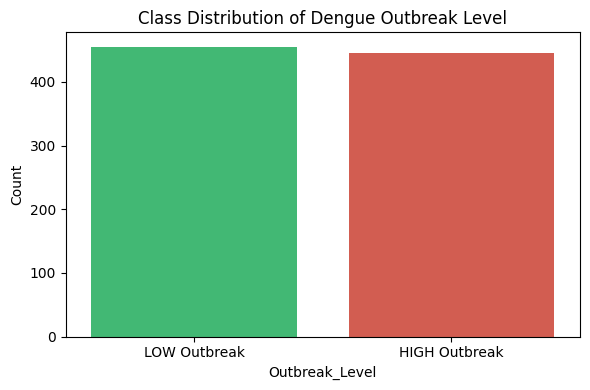

Plot saved!


In [4]:
# CELL 3: Preprocessing and creating HIGH vs LOW target

# Create binary target
median_cases = df['Cases'].median()
print(f"Median cases: {median_cases}")
print(f"Rows above median (HIGH): {(df['Cases'] > median_cases).sum()}")
print(f"Rows below/equal median (LOW): {(df['Cases'] <= median_cases).sum()}")

df['Outbreak_Level'] = (df['Cases'] > median_cases).astype(int)

# Encode District only — province removed (redundant)
le_district = LabelEncoder()
df['District_encoded'] = le_district.fit_transform(df['District'])
print(f"Districts found: {list(le_district.classes_)}")

# Define features — clean and minimal
feature_cols = ['District_encoded', 'Elevation', 'Month',
                'Temp_avg', 'Precipitation_avg', 'Humidity_avg']

X = df[feature_cols]
y = df['Outbreak_Level']

print(f"\n Features shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

# Visualise class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y, palette=['#2ecc71','#e74c3c'])
plt.xticks([0,1], ['LOW Outbreak', 'HIGH Outbreak'])
plt.title('Class Distribution of Dengue Outbreak Level')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150)
plt.show()
print("Plot saved!")

In [5]:
# CELL 4: Split data into train / validation / test sets

# 70% train | 15% validation | 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp)

print(f"Training set   : {X_train.shape[0]} samples")
print(f"Validation set : {X_val.shape[0]} samples")
print(f"Test set       : {X_test.shape[0]} samples")

# Scale features
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc   = scaler.transform(X_val)
X_test_sc  = scaler.transform(X_test)

print("\n Data split and scaled successfully!")

Training set   : 630 samples
Validation set : 135 samples
Test set       : 135 samples

 Data split and scaled successfully!


XGBoost model trained successfully!


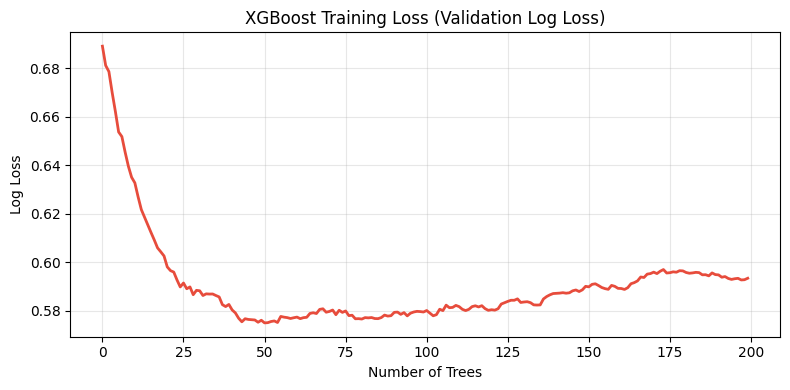

Training curve saved!


In [6]:
# CELL 5: Train XGBoost classifier

model = xgb.XGBClassifier(
    n_estimators=200,        # number of trees
    max_depth=4,             # how deep each tree grows
    learning_rate=0.05,      # how fast the model learns (slow = better)
    subsample=0.8,           # use 80% of data per tree (prevents overfitting)
    colsample_bytree=0.8,    # use 80% of features per tree
    eval_metric='logloss',
    random_state=42
)

model.fit(
    X_train_sc, y_train,
    eval_set=[(X_val_sc, y_val)],
    verbose=False
)

print("XGBoost model trained successfully!")

# Plot training loss curve
results = model.evals_result()
plt.figure(figsize=(8,4))
plt.plot(results['validation_0']['logloss'], color='#e74c3c', linewidth=2)
plt.title('XGBoost Training Loss (Validation Log Loss)')
plt.xlabel('Number of Trees')
plt.ylabel('Log Loss')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_curve.png', dpi=150)
plt.show()
print("Training curve saved!")

       MODEL PERFORMANCE ON TEST SET
  Accuracy  : 77.04%
  F1 Score  : 0.7737
  AUC-ROC   : 0.8448

--- Classification Report ---
               precision    recall  f1-score   support

 LOW Outbreak       0.78      0.75      0.77        68
HIGH Outbreak       0.76      0.79      0.77        67

     accuracy                           0.77       135
    macro avg       0.77      0.77      0.77       135
 weighted avg       0.77      0.77      0.77       135



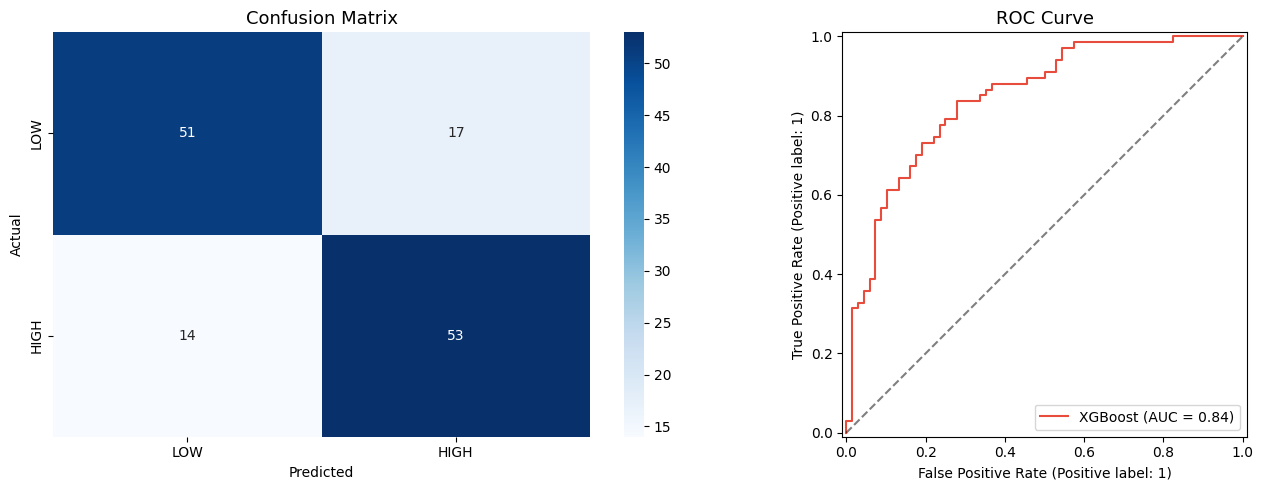

Evaluation plots saved!


In [7]:
# CELL 6: Evaluate model performance on test set

y_pred = model.predict(X_test_sc)
y_prob = model.predict_proba(X_test_sc)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("=" * 45)
print("       MODEL PERFORMANCE ON TEST SET")
print("=" * 45)
print(f"  Accuracy  : {acc*100:.2f}%")
print(f"  F1 Score  : {f1:.4f}")
print(f"  AUC-ROC   : {auc:.4f}")
print("=" * 45)
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred,
      target_names=['LOW Outbreak', 'HIGH Outbreak']))

# Confusion Matrix + ROC Curve side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['LOW','HIGH'],
            yticklabels=['LOW','HIGH'])
axes[0].set_title('Confusion Matrix', fontsize=13)
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_prob,
    ax=axes[1], name='XGBoost', color='#e74c3c')
axes[1].plot([0,1],[0,1],'k--', alpha=0.5)
axes[1].set_title('ROC Curve', fontsize=13)

plt.tight_layout()
plt.savefig('evaluation_plots.png', dpi=150, bbox_inches='tight')
plt.show()
print("Evaluation plots saved!")

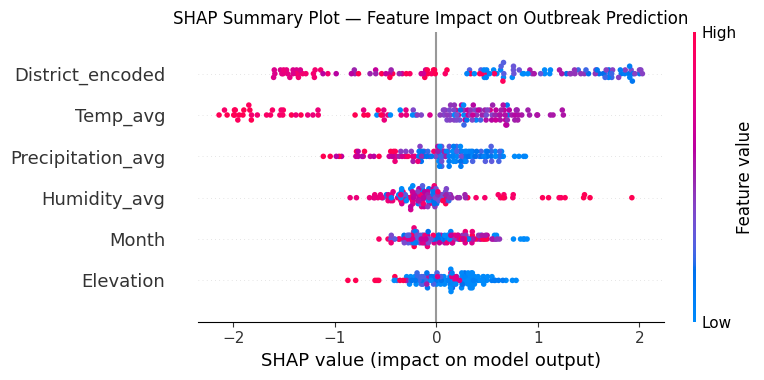

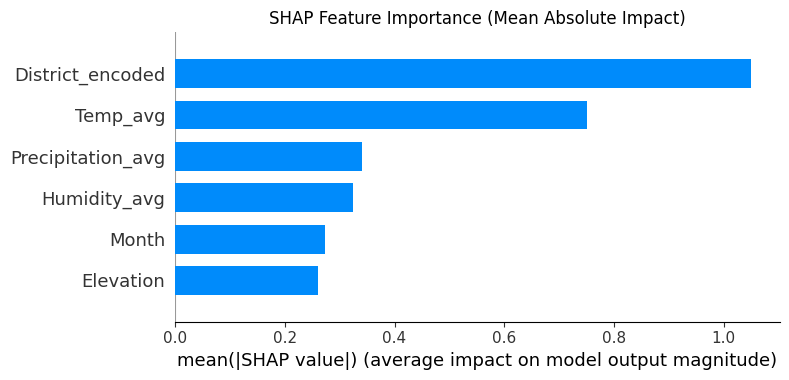

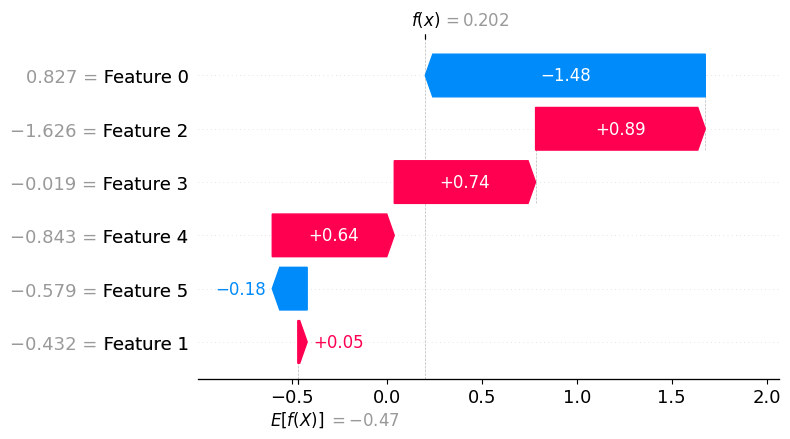

All SHAP plots saved!


In [8]:
# CELL 7: SHAP Explainability

X_test_df = pd.DataFrame(X_test_sc, columns=feature_cols)

explainer   = shap.Explainer(model, X_train_sc)
shap_values = explainer(X_test_sc)

# Plot 1: Summary dot plot (shows direction of each feature's impact)
plt.figure()
shap.summary_plot(shap_values, X_test_df, show=False)
plt.title("SHAP Summary Plot — Feature Impact on Outbreak Prediction")
plt.tight_layout()
plt.savefig('shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot 2: Bar chart (overall importance ranking)
plt.figure()
shap.summary_plot(shap_values, X_test_df, plot_type='bar', show=False)
plt.title("SHAP Feature Importance (Mean Absolute Impact)")
plt.tight_layout()
plt.savefig('shap_bar.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot 3: Single prediction waterfall (explain one specific case)
plt.figure()
shap.plots.waterfall(shap_values[0], show=False)
plt.tight_layout()
plt.savefig('shap_waterfall.png', dpi=150, bbox_inches='tight')
plt.show()

print("All SHAP plots saved!")

In [9]:
# CELL 8: Save model files and download all outputs

import pickle

with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('le_district.pkl', 'wb') as f:
    pickle.dump(le_district, f)

# Save feature column list
import json
with open('feature_cols.json', 'w') as f:
    json.dump(feature_cols, f)

# Download all files
from google.colab import files
for fname in ['xgb_model.pkl', 'scaler.pkl', 'le_district.pkl',
              'feature_cols.json', 'class_distribution.png',
              'training_curve.png', 'evaluation_plots.png',
              'shap_summary.png', 'shap_bar.png', 'shap_waterfall.png']:
    files.download(fname)

print("All files downloaded!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All files downloaded!
